**1. Wczytanie i przygotowanie danych**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Wczytanie danych
df = sns.load_dataset('titanic')

# 2. Czyszczenie danych (zgodnie z poprzednim schematem)
# Usuwamy kolumny z dużą ilością braków lub nieprzydatne
cols_to_drop = ['deck', 'embark_town', 'alive', 'who', 'adult_male', 'class']
df_clean = df.drop(columns=cols_to_drop)

# Uzupełnianie braków (wiek medianą, port modą)
df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())
df_clean['embarked'] = df_clean['embarked'].fillna(df_clean['embarked'].mode()[0])

# 3. Kodowanie zmiennych kategorycznych (One-Hot Encoding)
df_model = pd.get_dummies(df_clean, columns=['sex', 'embarked'], drop_first=True)

# 4. Podział na cechy (X) i cel (y)
X = df_model.drop('survived', axis=1)
y = df_model['survived']

# 5. Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Dane przygotowane.")
print(f"Zbiór treningowy: {X_train.shape}")

Dane przygotowane.
Zbiór treningowy: (712, 9)


**2. Drzewo decyzyjne - eksperymenty**


In [2]:
# Lista głębokości do przetestowania
depths = [2, 3, 5, 7, 10, None]
results_tree = []

print("\n--- WYNIKI DRZEWA DECYZYJNEGO ---")
print(f"{'Max Depth':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")

best_acc_tree = 0
best_model_tree = None
best_depth = 0

for depth in depths:
    # Trenowanie modelu
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Predykcja
    y_pred = clf.predict(X_test)

    # Obliczanie metryk
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Zapisywanie wyników
    results_tree.append({
        'Depth': str(depth), 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1
    })

    print(f"{str(depth):<12} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f}")

    # Szukanie najlepszego modelu (wg Accuracy)
    if acc > best_acc_tree:
        best_acc_tree = acc
        best_model_tree = clf
        best_depth = depth

print(f"\nNajlepsze drzewo dla max_depth = {best_depth} (Accuracy: {best_acc_tree:.4f})")


--- WYNIKI DRZEWA DECYZYJNEGO ---
Max Depth    Accuracy   Precision  Recall     F1        
2            0.7598     0.8611     0.4493     0.5905    
3            0.7933     0.8636     0.5507     0.6726    
5            0.7765     0.7544     0.6232     0.6825    
7            0.7989     0.8235     0.6087     0.7000    
10           0.7989     0.7619     0.6957     0.7273    
None         0.8156     0.7812     0.7246     0.7519    

Najlepsze drzewo dla max_depth = None (Accuracy: 0.8156)


Zbyt małe max_depth (np. 2) powoduje niedouczenie (model jest zbyt prosty). Zbyt duże max_depth (np. 10 lub None) zazwyczaj prowadzi do przeuczenia – model świetnie działa na danych treningowych, ale gorzej na testowych (spada accuracy). Najlepsze wyniki zazwyczaj uzyskuje się dla średnich wartości (np. 3-5).

Wizualizacja najlepszego drzewa

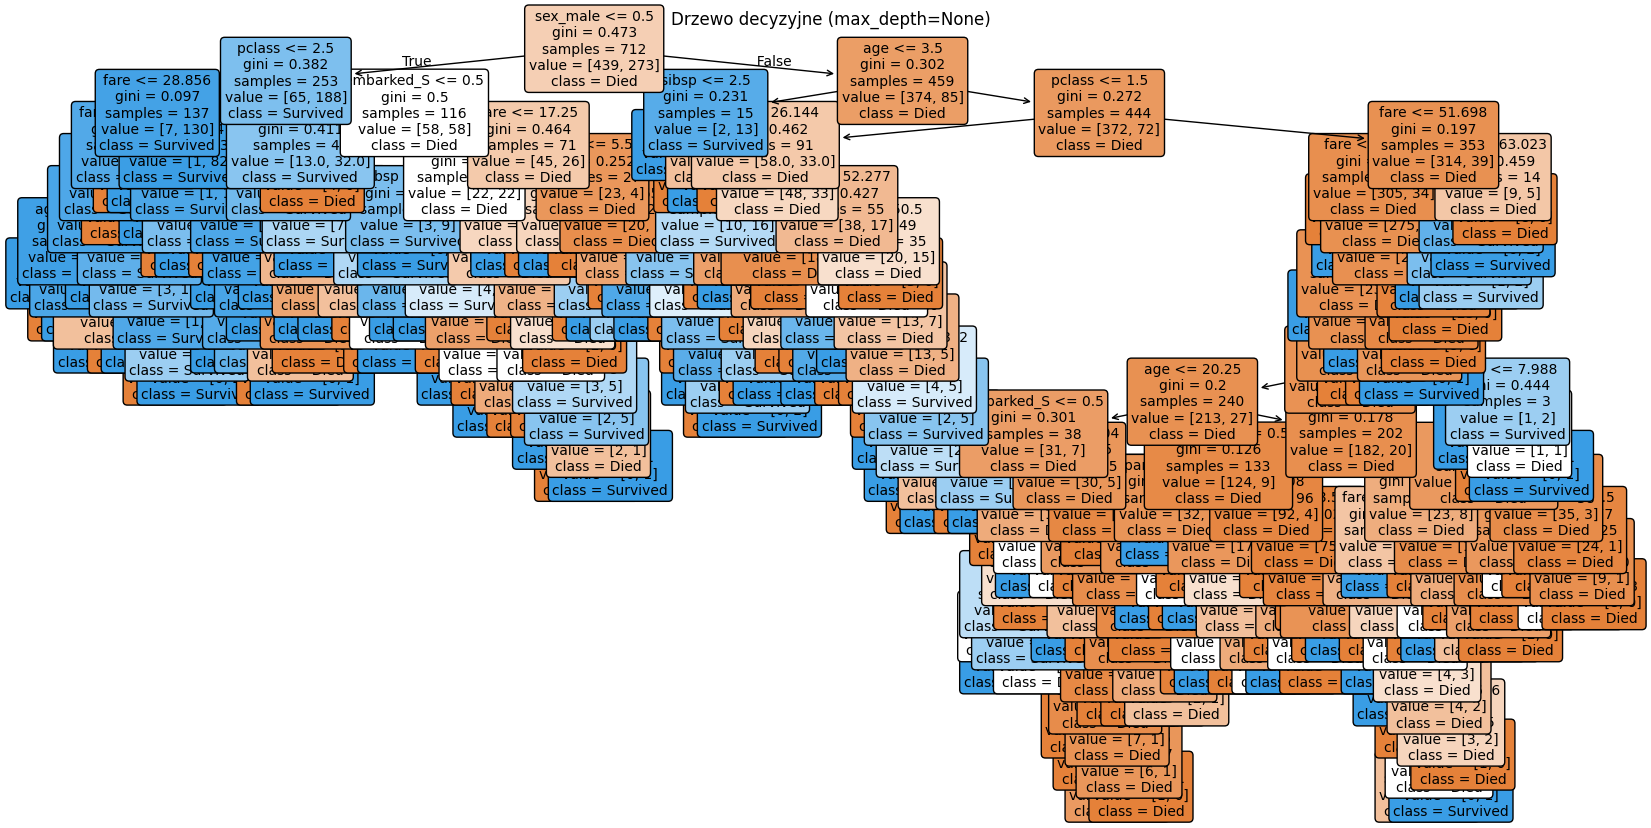

In [3]:
plt.figure(figsize=(20, 10))
plot_tree(best_model_tree,
          feature_names=X.columns,
          class_names=['Died', 'Survived'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f"Drzewo decyzyjne (max_depth={best_depth})")
plt.show()

Powyższe drzewo jest najlepsze matematycznie (wg Accuracy). Poniżej znajduje się bardziej czytelne, przejrzyste drzewo o mniejszej dokładności

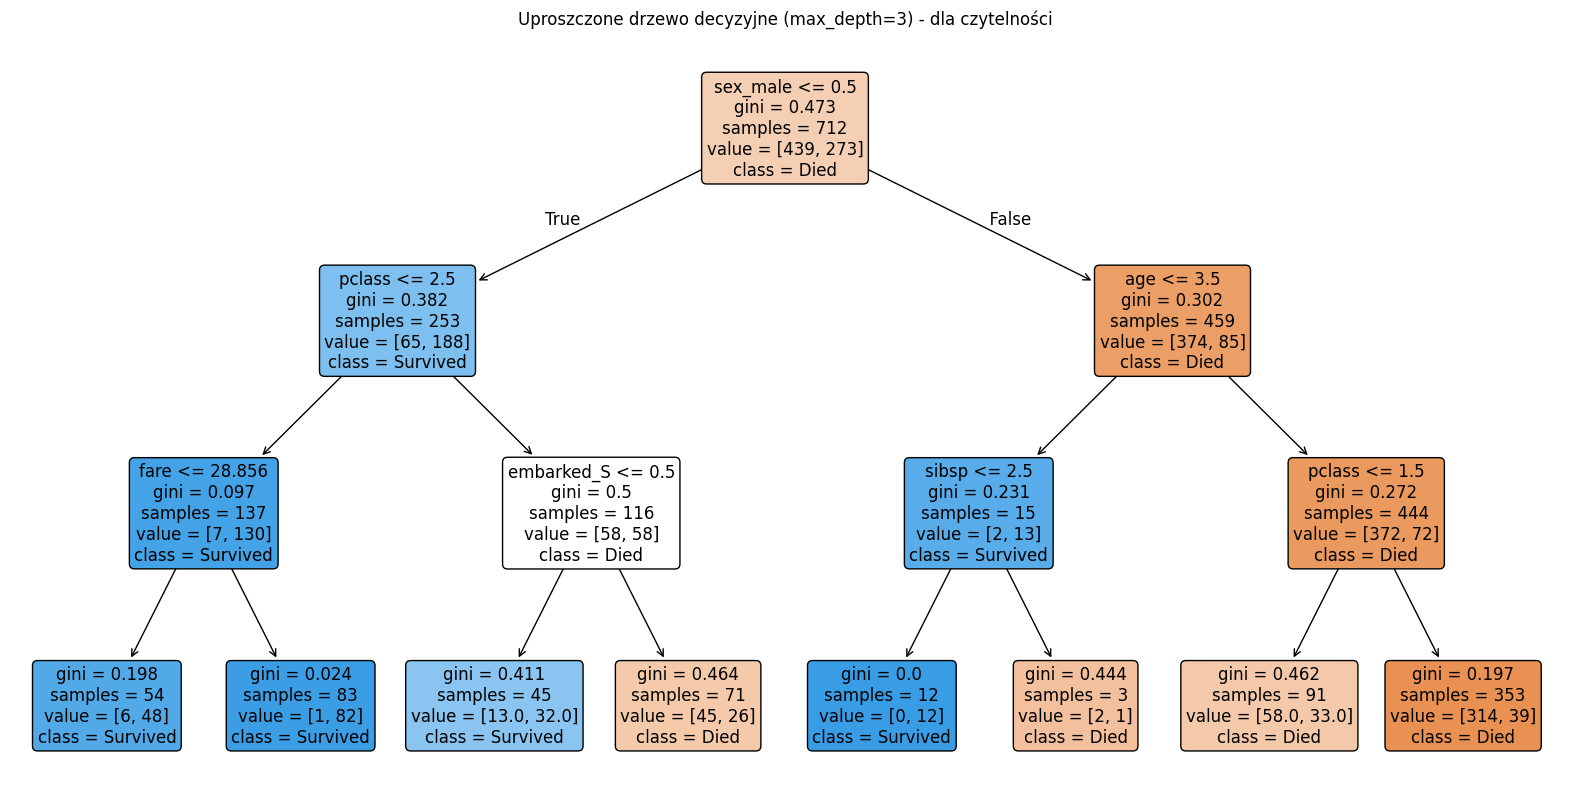

In [4]:
# Wymuszamy głębokość 3 dla celów wizualizacji (żeby było czytelne)
model_do_wizualizacji = DecisionTreeClassifier(max_depth=3, random_state=42)
model_do_wizualizacji.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(model_do_wizualizacji,
          feature_names=X.columns,
          class_names=['Died', 'Survived'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title("Uproszczone drzewo decyzyjne (max_depth=3) - dla czytelności")
plt.show()

**3. KNN - normalizacja i eksperymenty**


--- WYNIKI KNN ---
k     Accuracy  
1     0.7486    
3     0.8045    
5     0.8101    
7     0.7933    
9     0.7933    
11    0.8045    
15    0.8324    


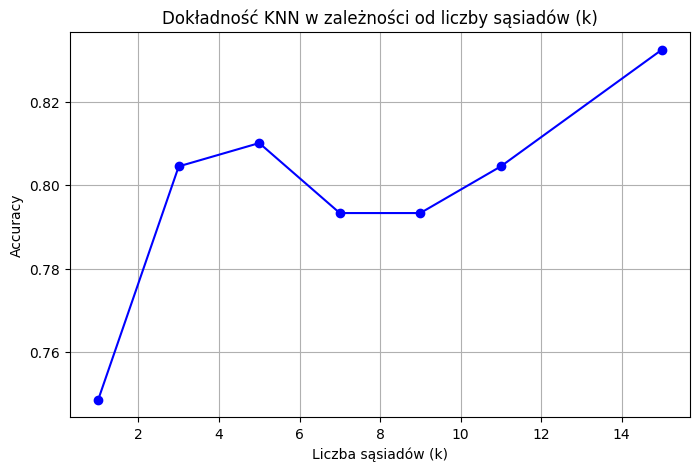


Optymalne k: 15 (Accuracy: 0.8324)


In [5]:
# 1. Normalizacja (StandardScaler) - Kluczowe dla KNN!
scaler = StandardScaler()

# Dopasowujemy skaler tylko na zbiorze treningowym
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Eksperyment z różnymi wartościami k
k_values = [1, 3, 5, 7, 9, 11, 15]
accuracies_knn = []

print("\n--- WYNIKI KNN ---")
print(f"{'k':<5} {'Accuracy':<10}")

for k in k_values:
    # Trenowanie modelu KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Predykcja
    y_pred_knn = knn.predict(X_test_scaled)
    acc_knn = accuracy_score(y_test, y_pred_knn)

    accuracies_knn.append(acc_knn)
    print(f"{k:<5} {acc_knn:<10.4f}")

# Wykres Accuracy w funkcji k
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_knn, marker='o', linestyle='-', color='blue')
plt.title('Dokładność KNN w zależności od liczby sąsiadów (k)')
plt.xlabel('Liczba sąsiadów (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Znalezienie optymalnego k
best_k_idx = accuracies_knn.index(max(accuracies_knn))
print(f"\nOptymalne k: {k_values[best_k_idx]} (Accuracy: {max(accuracies_knn):.4f})")

Zbyt małe k (np. 1) sprawia, że model jest bardzo wrażliwy na szum (każdy odstający punkt zmienia decyzję). Zbyt duże k zbytnio wygładza granice decyzyjne, ignorując lokalne wzorce. Optymalne k to zazwyczaj wartość środkowa, która zapewnia balans (często w okolicach 5-11 dla tego zbioru).

**4. Wnioski i porównanie**

In [6]:
print("--- PODSUMOWANIE I WNIOSKI ---")
print(f"Najlepszy wynik Drzewa Decyzyjnego: {best_acc_tree:.4f}")
print(f"Najlepszy wynik KNN: {max(accuracies_knn):.4f}")

if best_acc_tree > max(accuracies_knn):
    print("Wniosek: Na tym zbiorze danych Drzewo Decyzyjne poradziło sobie lepiej.")
else:
    print("Wniosek: Na tym zbiorze danych KNN poradził sobie lepiej.")

print("\nKluczowe obserwacje:")
print("1. KNN wymagał skalowania danych, Drzewo Decyzyjne nie.")
print("2. Drzewo jest łatwiejsze w interpretacji (można narysować wykres).")
print("3. KNN jest znacznie wolniejszy przy dużej liczbie danych (liczy odległości).")

--- PODSUMOWANIE I WNIOSKI ---
Najlepszy wynik Drzewa Decyzyjnego: 0.8156
Najlepszy wynik KNN: 0.8324
Wniosek: Na tym zbiorze danych KNN poradził sobie lepiej.

Kluczowe obserwacje:
1. KNN wymagał skalowania danych, Drzewo Decyzyjne nie.
2. Drzewo jest łatwiejsze w interpretacji (można narysować wykres).
3. KNN jest znacznie wolniejszy przy dużej liczbie danych (liczy odległości).
